# **Sentiment Analysis of Pfizer and BioNTech Vaccine Tweets**

The Pfizer-BioNTech COVID-19 vaccine, also known as BNT162b2, is a mRNA-based vaccine developed to combat the COVID-19 pandemic. It was one of the first vaccines to receive emergency use authorization. The vaccine works by introducing a small piece of the virus's genetic material into the body, triggering an immune response. Clinical trials have shown high efficacy rates in preventing symptomatic COVID-19 infection. It requires two doses administered a few weeks apart. The Pfizer-BioNTech vaccine has been widely distributed globally and played a significant role in vaccination campaigns, contributing to efforts to control the spread of the COVID-19 virus. And this vaccine is authorized for use in individuals aged 12 years and older in many countries, including the United States and the European Union. However, the specific age groups eligible for vaccination may vary depending on the regulations and guidelines established by each country's health authorities.

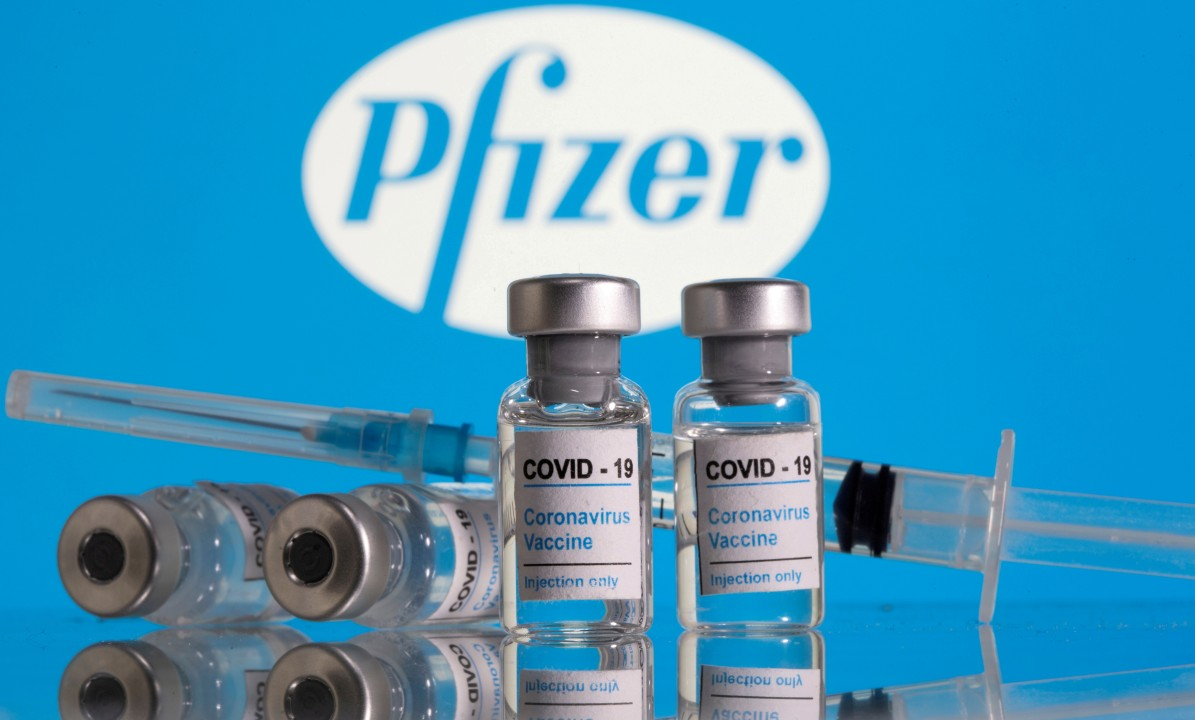

In [ ]:
from PIL import Image
img = Image.open('pfizer.jpg')
img

In [5]:
!pip install kaggle

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d gpreda/pfizer-vaccine-tweets

 57% 1.00M/1.76M [00:00<00:00, 1.47MB/s]
100% 1.76M/1.76M [00:00<00:00, 2.27MB/s]


In [8]:
from zipfile import ZipFile
dataset = '/content/pfizer-vaccine-tweets.zip'

with ZipFile(dataset,'r')as new_dataset:
  new_dataset.extractall()
  print("The dataset is extracted")

The dataset is extracted


Import basic libraries

In [ ]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Import dataset

In [ ]:
data = pd.read_csv('vaccination_tweets.csv')
data.head()

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4  2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet  
0         0          0       False  
1         1          1       False  
2         0          0       False  
3       446       2129       False  
4         0          0       False

Analysing the dataset

In [ ]:
data.shape

(11020, 16)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                11020 non-null  int64 
 1   user_name         11020 non-null  object
 2   user_location     8750 non-null   object
 3   user_description  10341 non-null  object
 4   user_created      11020 non-null  object
 5   user_followers    11020 non-null  int64 
 6   user_friends      11020 non-null  int64 
 7   user_favourites   11020 non-null  int64 
 8   user_verified     11020 non-null  bool  
 9   date              11020 non-null  object
 10  text              11020 non-null  object
 11  hashtags          8438 non-null   object
 12  source            11019 non-null  object
 13  retweets          11020 non-null  int64 
 14  favorites         11020 non-null  int64 
 15  is_retweet        11020 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.2+ MB


In [ ]:
data.describe()

id  user_followers   user_friends  user_favourites  \
count  1.102000e+04    1.102000e+04   11020.000000     1.102000e+04   
mean   1.372977e+18    3.518827e+04    1170.470236     1.533289e+04   
std    3.311622e+16    2.942509e+05    2798.429673     4.944401e+04   
min    1.337728e+18    0.000000e+00       0.000000     0.000000e+00   
25%    1.347623e+18    1.110000e+02     164.000000     4.360000e+02   
50%    1.360274e+18    4.790000e+02     460.000000     2.323500e+03   
75%    1.395234e+18    2.171250e+03    1221.000000     1.114075e+04   
max    1.463244e+18    1.371493e+07  103226.000000     1.213794e+06   

           retweets     favorites  
count  11020.000000  11020.000000  
mean       1.360436      7.510617  
std       11.364732     51.192608  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      1.000000  
75%        1.000000      4.000000  
max      678.000000   2315.000000

In [ ]:
data.isnull()

id  user_name  user_location  user_description  user_created  \
0      False      False          False             False         False   
1      False      False          False             False         False   
2      False      False          False             False         False   
3      False      False          False             False         False   
4      False      False           True             False         False   
...      ...        ...            ...               ...           ...   
11015  False      False          False             False         False   
11016  False      False           True             False         False   
11017  False      False          False             False         False   
11018  False      False          False             False         False   
11019  False      False          False             False         False   

       user_followers  user_friends  user_favourites  user_verified   date  \
0               False         False            False          False  False   
1               False         False            False          False  False   
2               False         False            False          False  False   
3               False         False            False          False  False   
4               False         False            False          False  False   
...               ...           ...              ...            ...    ...   
11015           False         False            False          False  False   
11016           False         False            False          False  False   
11017           False         False            False          False  False   
11018           False         False            False          False  False   
11019           False         False            False          False  False   

        text  hashtags  source  retweets  favorites  is_retweet  
0      False     False   False     False      False       False  
1      False      True   False     False      False       False  
2      False     False   False     False      False       False  
3      False      True   False     False      False       False  
4      False     False   False     False      False       False  
...      ...       ...     ...       ...        ...         ...  
11015  False      True   False     False      False       False  
11016  False     False   False     False      False       False  
11017  False      True   False     False      False       False  
11018  False     False   False     False      False       False  
11019  False      True   False     False      False       False  

[11020 rows x 16 columns]

In [ ]:
data.isnull().sum()

id                     0
user_name              0
user_location       2270
user_description     679
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            2582
source                 1
retweets               0
favorites              0
is_retweet             0
dtype: int64

In [ ]:
data.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

Heatmap for identifying null values

<Axes: >

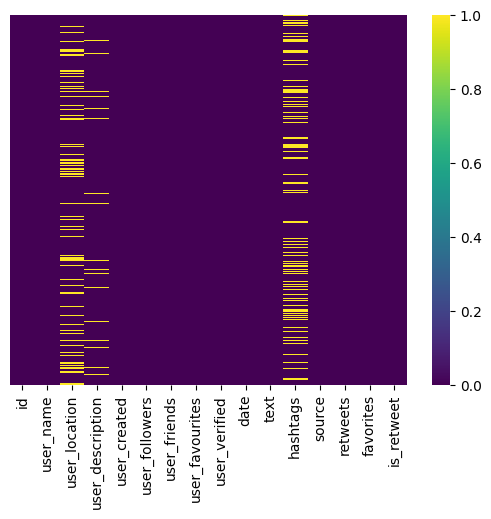

In [ ]:
sns.heatmap(data.isnull(),yticklabels=False,cmap="viridis")

The correlation matrix for the given dataset which provides a graphical representation of the relationships between different variables in the dataset.

In [ ]:
data1 = data.drop(['is_retweet'],axis = 1)

<Axes: >

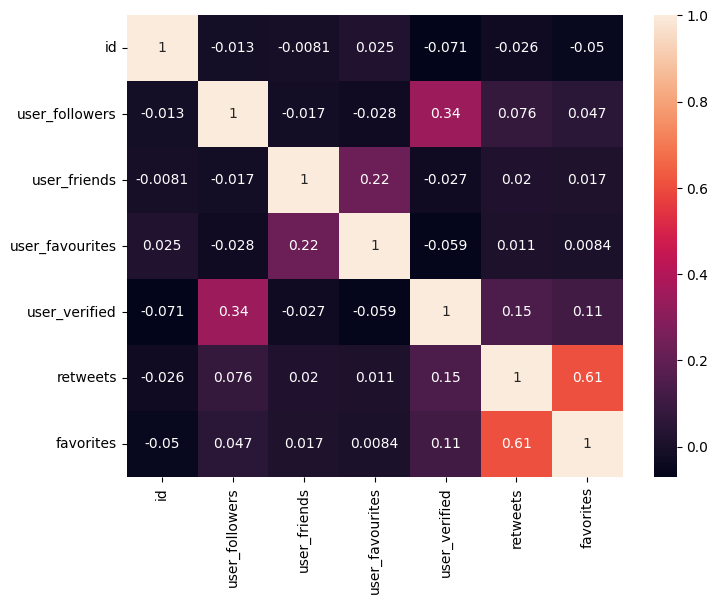

In [ ]:
corr=data1.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr,annot=True)

To create histogram using Plotly Express module for Pfizer vaccine tweets by date

In [ ]:
import plotly.express as px
px.histogram(data, x="date", opacity=.5, nbins=100,title="Pfizer Vaccine Tweets by date")

To analyse how many tweets from in verified accounts and not verified accounts

In [ ]:
data['user_verified'].value_counts()

False    10084
True       936
Name: user_verified, dtype: int64

<Axes: xlabel='user_verified', ylabel='count'>

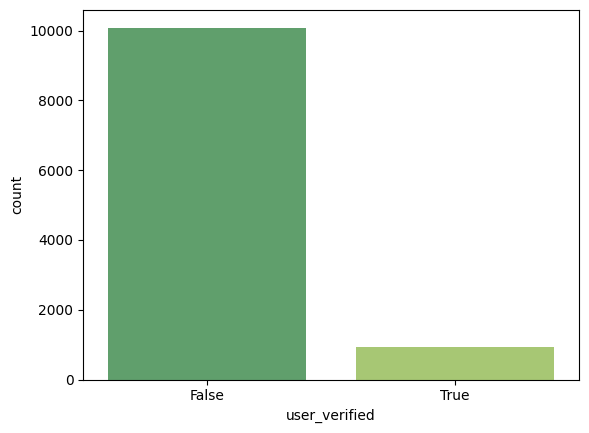

In [ ]:
sns.countplot(data=data, x='user_verified', palette='summer')

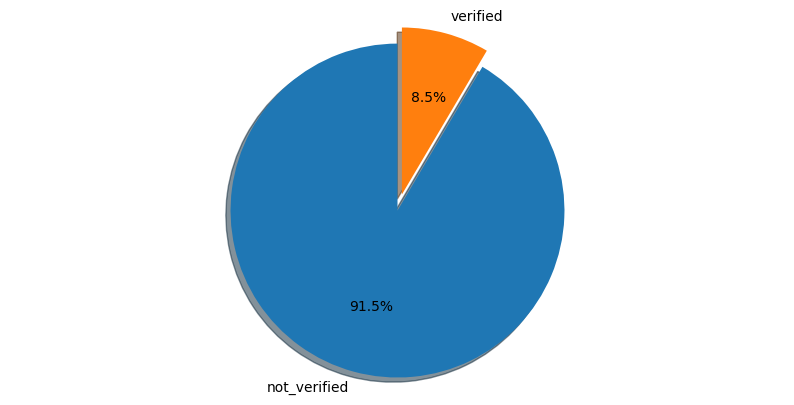

In [ ]:
labels = 'not_verified', 'verified'
size = (10084, 936)
explode = (0.1, 0)
plt.figure(figsize=(10,5))
plt.pie(size, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90);
plt.axis('equal')
plt.show()

To analyse which source is most prefer to tweet

In [ ]:
px.histogram(data, x="source", opacity=.5, nbins=100,title="The Source from the Pfizer Vaccine Tweets")

Drop the unwanted columns to predict the sentiment analysis

In [ ]:
data_text = data.drop(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],axis = 1)
data_text.head()

text
0  Same folks said daikon paste could treat a cyt...
1  While the world has been on the wrong side of ...
2  #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3  Facts are immutable, Senator, even when you're...
4  Explain to me again why we need a vaccine @Bor...

This function preprocesses the input text by converting it to lowercase, removing URLs, mentions, hashtags, punctuation, and stopwords. This preprocessing is commonly done before applying text analysis techniques such as sentiment analysis, classification, or topic modeling.

In [ ]:
def data_processing(text):
  text = text.lower()
  text = re.sub(r"https\S+|www\S+https\S+", '',text,flags=re.MULTILINE)
  text = re.sub(r'\@W+|\#',"",text)
  text = re.sub(r'[^\w\s]','',text)
  text_tokens = word_tokenize(text)
  filtered_text = [w for w in text_tokens if not w in stop_words]
  return " ".join(filtered_text)

In [ ]:
data_text['text'] = data_text['text'].apply(data_processing)

In [ ]:
data_text

text
0      folks said daikon paste could treat cytokine s...
1      world wrong side history year hopefully bigges...
2      coronavirus sputnikv astrazeneca pfizerbiontec...
3      facts immutable senator even youre ethically s...
4      explain need vaccine borisjohnson matthancock ...
...                                                  ...
11015  number covid19 cases today 17 november 2021 re...
11016                          first dose pfizerbiontech
11017  number covid19 cases today 16 november 2021 re...
11018  pfizerbiontech developed new pill paxlovid inc...
11019  number covid19 cases today 15 november 2021 re...

[11020 rows x 1 columns]

Removes duplicate rows from the DataFrame df_text based on the values in the 'text' column

In [ ]:
data_text = data_text.drop_duplicates('text')

Stemming function helps in normalization, simplification, and improving text analysis accuracy by grouping variations of words together

In [ ]:
stemmer = PorterStemmer()
def stemming(data):
  text = [stemmer.stem(word) for word in data]
  return data

In [ ]:
data_text['text'] = data_text['text'].apply(lambda x: stemming(x))

In [ ]:
data_text['text'].head()

0    folks said daikon paste could treat cytokine s...
1    world wrong side history year hopefully bigges...
2    coronavirus sputnikv astrazeneca pfizerbiontec...
3    facts immutable senator even youre ethically s...
4    explain need vaccine borisjohnson matthancock ...
Name: text, dtype: object

To use text_blob to calculate polarity of the sentences

In [ ]:
def polarity(text):
  return TextBlob(text).sentiment.polarity

In [ ]:
data_text['polarity'] = data_text['text'].apply(polarity)

In [ ]:
data_text.head(10)

text  polarity
0  folks said daikon paste could treat cytokine s...     0.000
1  world wrong side history year hopefully bigges...    -0.500
2  coronavirus sputnikv astrazeneca pfizerbiontec...     0.000
3  facts immutable senator even youre ethically s...     0.100
4  explain need vaccine borisjohnson matthancock ...     0.000
5  anyone useful adviceguidance whether covid vac...     0.400
6  bit sad claim fame success vaccination patriot...    -0.100
7  many bright days 2020 best 1 bidenharris winni...     0.675
8  covid vaccine getting covidvaccine covid19 pfi...     0.000
9  covidvaccine states start getting covid19vacci...     0.000

To create the 'sentiment' column in the dataframe

In [ ]:
def sentiment(label):
  if label > 0:
    return "Positive"
  elif label == 0:
    return "Neutral"
  else:
    return "Negative"

In [ ]:
data_text['sentiment'] = data_text['polarity'].apply(sentiment)

In [ ]:
data_text.head()

text  polarity sentiment
0  folks said daikon paste could treat cytokine s...       0.0   Neutral
1  world wrong side history year hopefully bigges...      -0.5  Negative
2  coronavirus sputnikv astrazeneca pfizerbiontec...       0.0   Neutral
3  facts immutable senator even youre ethically s...       0.1  Positive
4  explain need vaccine borisjohnson matthancock ...       0.0   Neutral

Text(0.5, 1.0, 'Vaccination Tweets Sentiments')

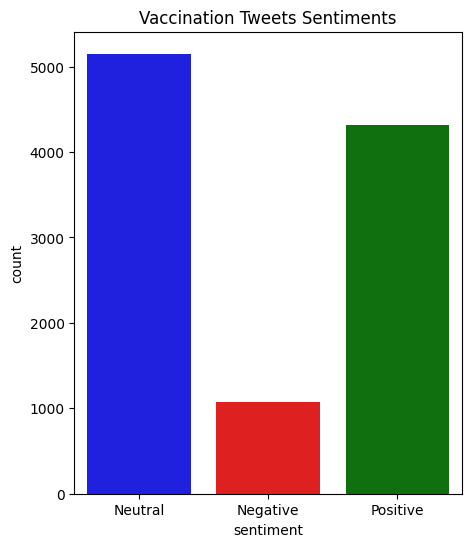

In [ ]:
bar = plt.figure(figsize=(5,6))
sns.countplot(x='sentiment', data = data_text, palette=['blue','red','green'])
plt.title('Vaccination Tweets Sentiments')

Text(0.5, 1.0, 'Vaccination Tweets Sentiments')

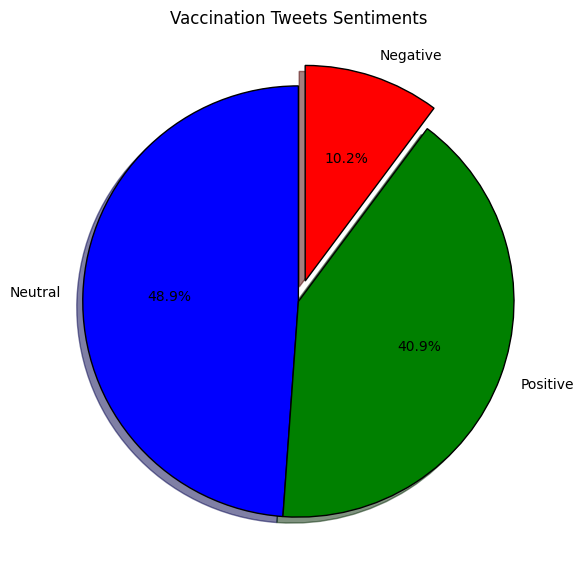

In [ ]:
pie = plt.figure(figsize=(7,7))
colors = ("blue","green","red")
wp = {'linewidth':1, 'edgecolor':'black'}
tags = data_text['sentiment'].value_counts()
explode = (0,0,0.1)
tags.plot(kind='pie',autopct='%1.1f%%',shadow=True,colors=colors,startangle=90,wedgeprops=wp,explode=explode,label='')
plt.title('Vaccination Tweets Sentiments')

Top 5 positive sentiments

In [ ]:
positive_tweet = data_text[data_text.sentiment == 'Positive']
positive_tweet = positive_tweet.sort_values(['polarity'],ascending=False)
positive_tweet.head()

text  polarity sentiment
9317  best way get merrygoround pfizer pfizerbiontec...       1.0  Positive
2340  applying emotion pfizerbiontech based best evi...       1.0  Positive
6295  pfizer jab morning efficient wellorganised tha...       1.0  Positive
5041  get art printed awesome products support redbu...       1.0  Positive
1055  already vaccinated getting vaccine soon plan t...       1.0  Positive

Wordcloud for visualize the positive tweets

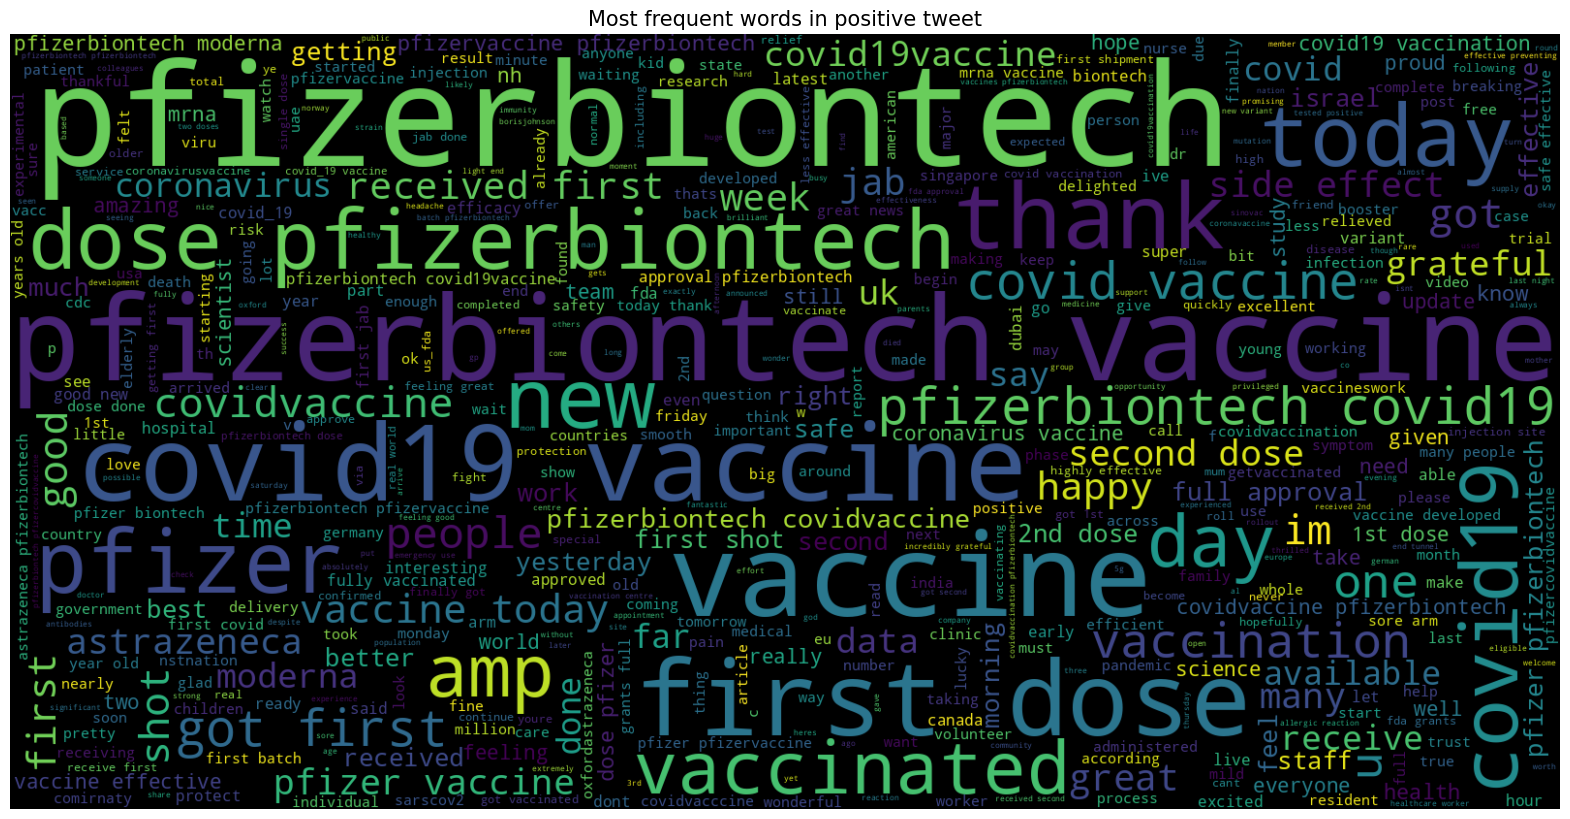

In [ ]:
text = ' '.join([word for word in positive_tweet['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500,width=1600,height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweet',fontsize=15)
plt.show()

Top 5 negative sentiments

In [ ]:
negative_tweet = data_text[data_text.sentiment == 'Negative']
negative_tweet = negative_tweet.sort_values(['polarity'],ascending=False)
negative_tweet.head()

text  polarity sentiment
2912  work skilled nursing facility got first vaccin... -0.003333  Negative
7256  200321 752308 vaccinations new daily record da... -0.003409  Negative
2073  ukgovernment cant even vaccinate properly ethi... -0.004762  Negative
7715  got first dose less waiting time airport vacci... -0.005556  Negative
7157  nas_k27 second dose due end next month well fa... -0.006250  Negative

Wordcloud for visualize the negative tweets

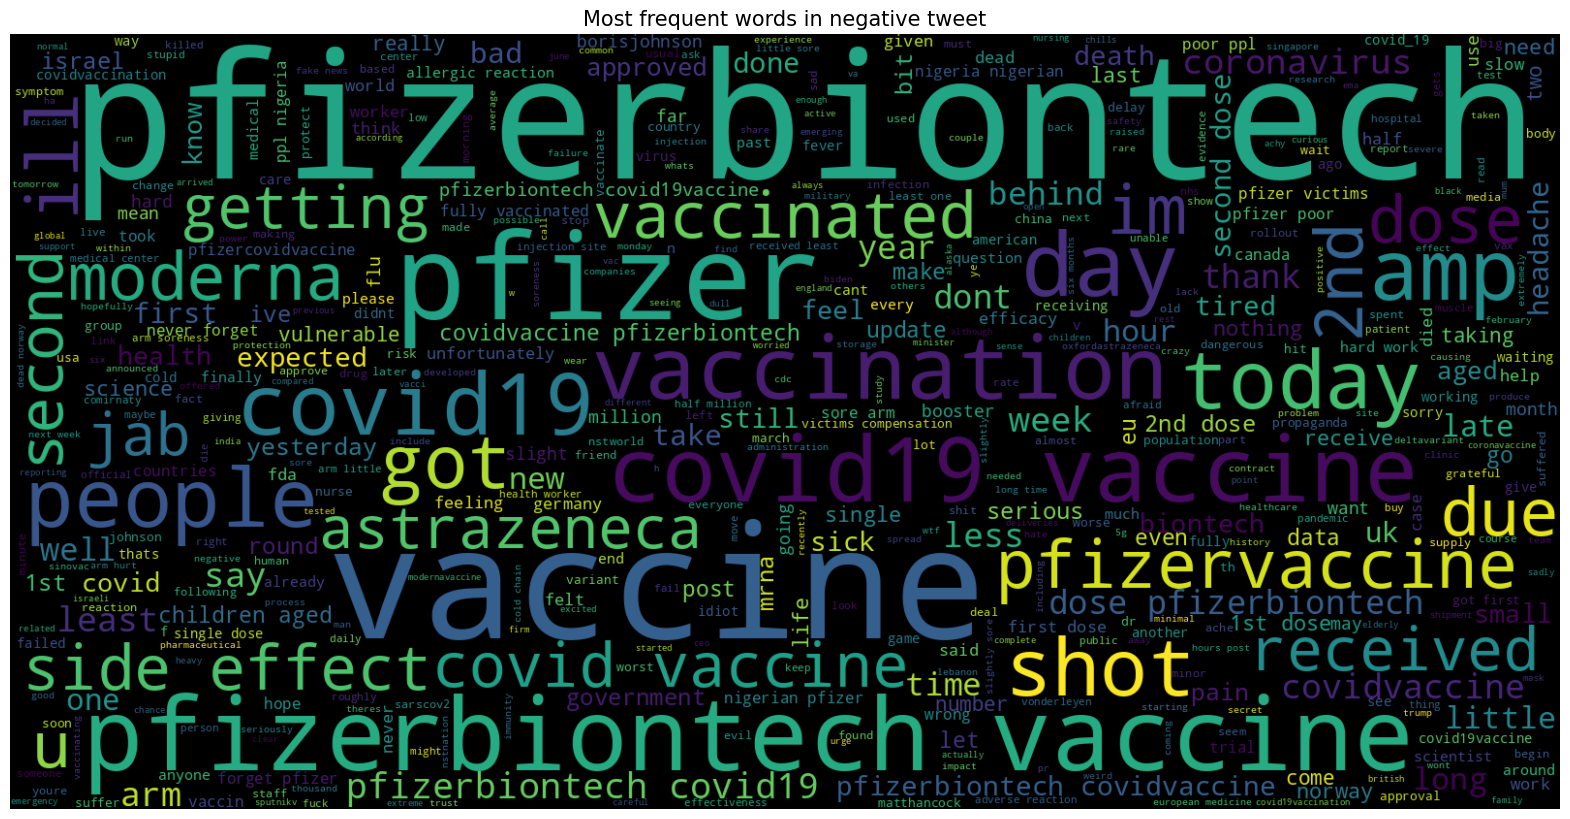

In [ ]:
text = ' '.join([word for word in negative_tweet['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500,width=1600,height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweet',fontsize=15)
plt.show()

Top 5 netural sentiments

In [ ]:
neutral_tweet = data_text[data_text.sentiment == 'Neutral']
neutral_tweet = neutral_tweet.sort_values(['polarity'],ascending=False)
neutral_tweet.head()

text  polarity sentiment
0     folks said daikon paste could treat cytokine s...       0.0   Neutral
7347  anyone else feel like framing vaccine card pfi...       0.0   Neutral
7458  looking forward getting second pfizer shot any...       0.0   Neutral
7454  never thought id running diff vaccine modernav...       0.0   Neutral
7453  john___m dont get choose one person know asked...       0.0   Neutral

Wordcloud for visualize the netural sentiments

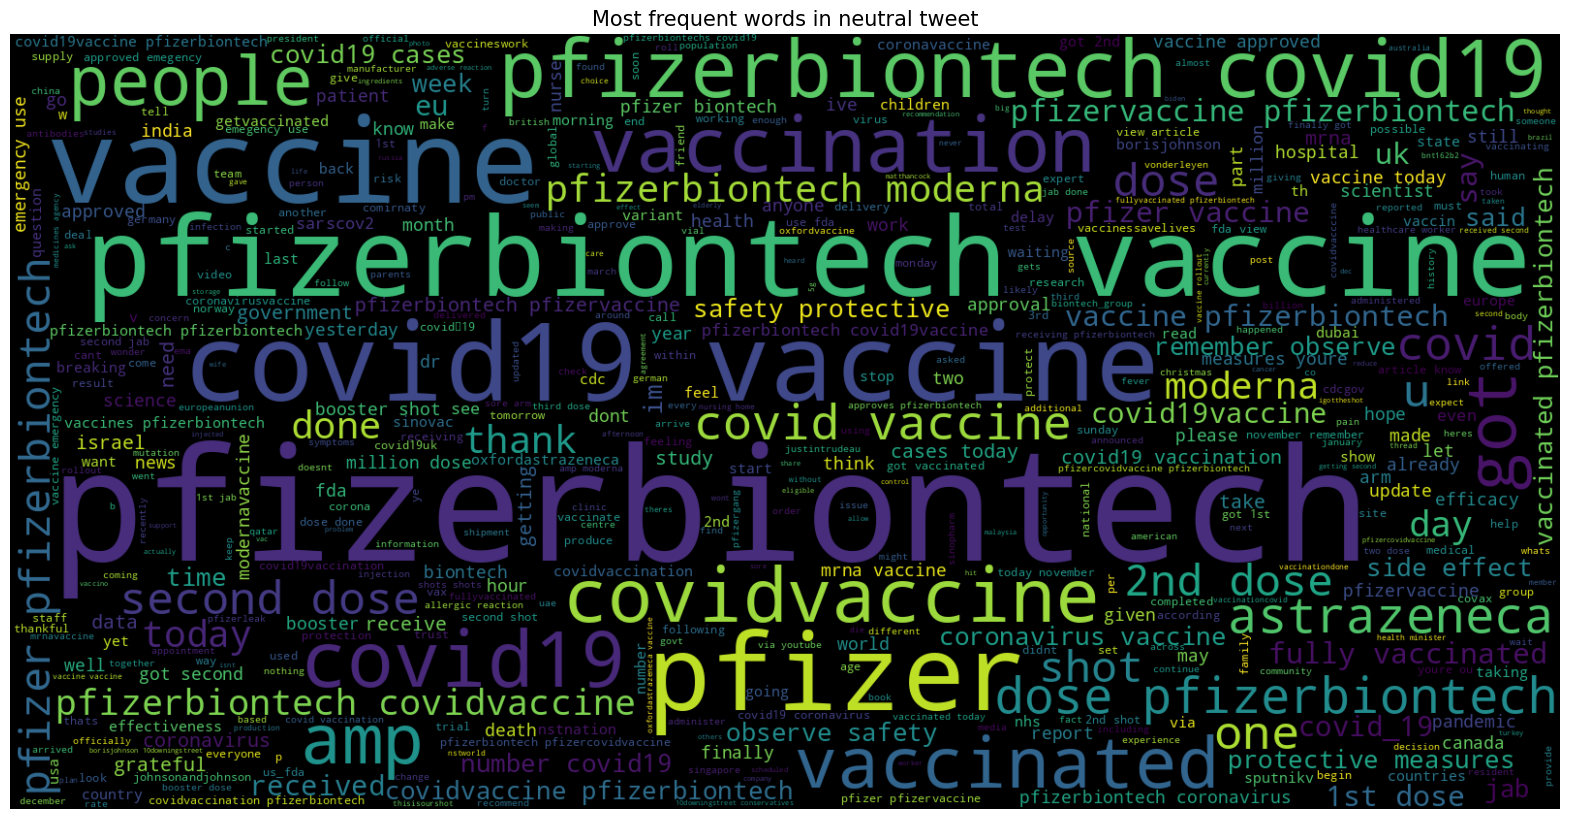

In [ ]:
text = ' '.join([word for word in neutral_tweet['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500,width=1600,height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweet',fontsize=15)
plt.show()

Vectorizing the data using count vector create a bigram model


In [ ]:
vect = CountVectorizer(ngram_range=(1,2)).fit(data_text['text'])

In [ ]:
feature_names = vect.get_feature_names_out()
print("Name of features: {}\n".format(len(feature_names)))
print("First 20 features:\n {}".format(feature_names[:20]))

Name of features: 78534

First 20 features:
 ['000' '000 doses' '000 initial' '000 people' '000 vaccines' '0000001'
 '0000001 covid19' '0011' '0011 abt' '004' '004 covid' '004 israelis' '01'
 '01 getting' '01 june' '01 november' '01aug2021' '01aug2021 doublevaxxed'
 '02' '02 175']


Train and Test using Logistic Regression model

In [ ]:
X = data_text['text']
Y = data_text['sentiment']
X = vect.transform(X)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [ ]:
model = LogisticRegression()
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
Accuracy = accuracy_score(y_pred, Y_test)
print("Test accuracy: {:.2f}%".format(Accuracy*100))
print("\n Confusion Matrix: \n", confusion_matrix(Y_test,y_pred))
print("\n Classification Report: \n", classification_report(Y_test,y_pred))

Test accuracy: 84.64%

 Confusion Matrix: 
 [[  72  116   38]
 [   4 1008    9]
 [   8  149  705]]

 Classification Report: 
               precision    recall  f1-score   support

    Negative       0.86      0.32      0.46       226
     Neutral       0.79      0.99      0.88      1021
    Positive       0.94      0.82      0.87       862

    accuracy                           0.85      2109
   macro avg       0.86      0.71      0.74      2109
weighted avg       0.86      0.85      0.83      2109

